# Rest API's  in Python (with a Focus on FastAPI)

A REST API (also known as RESTful API) is an application programming interface (API or web API) that conforms to the constraints of REST architectural style and allows for interaction with RESTful web services. REST stands for representational state transfer and was created by computer scientist Roy Fielding. (source [RedHat](https://www.redhat.com/en/topics/api/what-is-a-rest-api)).

At a basic level, a REST API is a simple and standardized way for different software applications to communicate over the internet using HTTP methods (like GET, POST, PUT, DELETE). It enables applications to access, create, update, and delete resources (like data objects) in a structured and predictable manner. REST APIs make it easy for developers to build and integrate applications, share data, and add functionality across different platforms.

If you want to create a REST API in Python, your main options are:

* Flask: A web application framework based on the Werkzeg WSGI toolkit and jinja2 templating; can be used for full stack development or API development. https://flask.palletsprojects.com/en/2.2.x/
* Django Rest Framework: a toolkit built off of the web application framework Django specifically intended for Rest API development. https://www.django-rest-framework.org/
* FastAPI: A web framework specifically designed for building APIs. https://fastapi.tiangolo.com/
* Tornado: I do not have as much experience with this framework. Upon research, it looks like it is faster than Django and Flask, but still lacks the speed of FastAPI. The framework is built using non-blocking network I/O, which makes it good at handling a large number of simultaneous connections. https://www.tornadoweb.org/en/stable/

Today, we will be focusing on FastAPI because, well, it is fast. Very fast. FastAPI is currently the fastest Python API framework, competing with the likes of golang (see [source](https://www.techempower.com/benchmarks/#section=test&runid=7464e520-0dc2-473d-bd34-dbdfd7e85911&hw=cl&test=query&l=hra0hr-2yn)). In addition to that, FastAPI is fairly flexible and easy to use as we will see.


## Index

* [Setup](#Setup)
* [Basics](#Basics)
* [Advanced Features](#Advanced-Features)
* [Testing and Deployment](#Testing-and-Deployments)
* Conclusion

## Setup

In order to set up a basic FastAPI Rest API, all you have to do is run:

```python
pip install fastapi[all]
```

The above install gives us everything we need to bring up a basic instance, including `uvicorn` for bringing up the web server and `sqlalchemy` for db object management

In later sections, we will be making use of dependency injection and shared database connections, so you will also need the following to create a local database:

```python
pip install aiosqlite 
```

**NOTE**: These dependencies have already been added to the top level requirements.txt, so make sure you update your code dojo environment before continuing.

## Basics

Okay, let's go over the basic REST operations, GET, POST, PUT, DELETE. 

One note here, it is going to be a bit tricky to show FastAPI working in a Jupyter notebook. SO, for each example, I will print the code here, then also save the code to a file in this directory so I can run each API instance from the notebook.

### Methods

Strictly speaking, in the original formulation of REST architecture, there are 4 available methods, GET, POST, PUT, and DELETE. However, in practice, there is an additional method we will discuss below in the context of FastAPI:


1). **GET**: Retrieves a resource from the server. In REST, this method is used for reading data without modifying it. In FastAPI, you can define a route handler function with the @app.get() decorator:

```python
@app.get("/api/v1/animals/{animal_id}")
def read_animal(animal_id: int):
    if animal_id in animal_cache:
        return {"animal": animal_cache[animal_id].dict()}
    else:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )
```

2). **POST**: Creates a new resource. In REST, this method is used to add a new resource to a collection and can be defined with a route handler function using the @app.post() decorator in FastAPI:

```python
@app.post("/api/v1/animals/")
def insert_animal(animal: Animal):
    new_id = max(animal_cache.keys() or [0])
    animal_cache[new_id] = animal
    return {"animal": animal}
```

3). **PUT**: Updates a resource by replacing it with a new version. In REST, this method is used to update an existing resource entirely and can be defined with a route handler function using the @app.put() decorator in FastAPI:

```python
@app.put("/api/v1/animals/{animal_id}")
def update_item(animal_id: int, animal: Animal):
    if animal_id in animal_cache:
        animal_cache[animal_id] = animal
        return {"animal_id": animal_id, "animal": animal_cache[animal_id]}
    else:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )

```

4). **PATCH**: This is the method that was not originally included in Roy Fielding's proposal for REST architecture, but was later introduced as a partial PUT is not "RESTful" ([further reading](https://williamdurand.fr/2014/02/14/please-dont-patch-like-that/)). Updates a resource by modifying only specific fields. In REST, this method is used to partially update an existing resource and can be defined with a route handler function using the @app.patch() decorator in FastAPI:

```python
@app.patch("/api/v1/animals/{animal_id}")
def update_animal_name(animal_id: int, animal: AnimalName):
    if animal_id in animal_cache:
        animal_cache[animal_id]["name"] = animal.name
        return {"animal_id": animal_id, "animal": animal_cache[animal_id]}
    else:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )
```

5). **DELETE**: Removes a resource. In REST, this method is specifically for removing an existing resource and can be defined with a route handler function using the @app.delete() decorator in FastAPI:

```python
@app.delete("/api/v1/animals/{animal_id}")
def delete_item(animal_id: int):
    if animal_id in animal_cache:
        del animal_cache[animal_id]
        return {"animal_id": animal_id, "message": "Animal removed"}
    else:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )
```

### Example One

Let's look at a quick example exhibiting the methods discussed above:

```python
# example_one.py -- Runs on http://localhost:8000

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel


class Animal(BaseModel):
    name: str
    species: str
    age: int
        

class AnimalName(BaseModel):
    name: str
        

app = FastAPI()

animal_cache = dict()


@app.get("/")
def read_root():
    return {"message": "Hello, FastAPI!"}


@app.get("/api/v1/animals")
def read_all_animals():
    return {"animals": animal_cache}



@app.get("/api/v1/animals/{animal_id}")
def read_animal(animal_id: int):
    if animal_id in animal_cache:
        return {"animal": animal_cache[animal_id].dict()}
    else:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )


@app.post("/api/v1/animals")
def insert_animal(animal: Animal):
    new_id = max(animal_cache.keys() or [0])
    animal_cache[new_id + 1] = animal
    return {"animal": animal}


@app.put("/api/v1/animals/{animal_id}")
def update_animal(animal_id: int, animal: Animal):
    if animal_id in animal_cache:
        animal_cache[animal_id] = animal
        return {"animal_id": animal_id, "animal": animal_cache[animal_id]}
    else:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )
        
        
@app.patch("/api/v1/animals/{animal_id}")
def update_animal_name(animal_id: int, animal: AnimalName):
    if animal_id in animal_cache:
        animal_record = animal_cache[animal_id]
        animal_data = animal.dict(exclude_unset=True)
        for key, value in animal_data.items():
            setattr(animal_record, key, value)
        animal_cache[animal_id] = animal_record
        return {"animal_id": animal_id, "animal": animal_cache[animal_id]}
    else:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )


@app.delete("/api/v1/animals/{animal_id}")
def delete_item(animal_id: int):
    if animal_id in animal_cache:
        del animal_cache[animal_id]
        return {"animal_id": animal_id, "message": "Animal removed"}
    else:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )

```

In [1]:
# need to force jupyter notebooks to let me run background processes

import os
get_ipython().system = os.system

In [16]:
!nohup python example_one.py > example_one.log 2>&1 &

0

In [3]:
!ps aux | grep "python example_one"  | grep -v grep

chasehudson      19356   0.4  0.1 409610416  48784   ??  S     4:13PM   0:00.24 python example_one.py


0

#### Intereacting with an API

Let's take a look at how we can call the methods above

In [4]:
import requests
import pprint


response = requests.get("http://localhost:8000/api/v1/animals")
pprint.pprint(response.json())

{'animals': {}}


In [5]:
headers = {'Content-type': 'application/json'}
dog = {"name": "Hamilton", "age": 4, "species": "canis lupus familiaris"}
response = requests.post("http://localhost:8000/api/v1/animals", headers=headers, json=dog)
pprint.pprint(response.json())

{'animal': {'age': 4, 'name': 'Hamilton', 'species': 'canis lupus familiaris'}}


In [6]:
response = requests.get("http://localhost:8000/api/v1/animals")
pprint.pprint(response.json())

{'animals': {'1': {'age': 4,
                   'name': 'Hamilton',
                   'species': 'canis lupus familiaris'}}}


In [7]:
headers = {'Content-type': 'application/json'}
donkey = {"name": "Cujo", "age": 6, "species": "equus asinus"}
response = requests.post("http://localhost:8000/api/v1/animals", headers=headers, json=donkey)
pprint.pprint(response.json())

{'animal': {'age': 6, 'name': 'Cujo', 'species': 'equus asinus'}}


In [8]:
response = requests.get("http://localhost:8000/api/v1/animals")
pprint.pprint(response.json())

{'animals': {'1': {'age': 4,
                   'name': 'Hamilton',
                   'species': 'canis lupus familiaris'},
             '2': {'age': 6, 'name': 'Cujo', 'species': 'equus asinus'}}}


In [9]:
horse = {"name": "Shadow", "age": 8, "species": "equus caballus"}
response = requests.put("http://localhost:8000/api/v1/animals/2", headers=headers, json=horse)
pprint.pprint(response.json())

{'animal': {'age': 8, 'name': 'Shadow', 'species': 'equus caballus'},
 'animal_id': 2}


In [10]:
response = requests.get("http://localhost:8000/api/v1/animals")
pprint.pprint(response.json())

{'animals': {'1': {'age': 4,
                   'name': 'Hamilton',
                   'species': 'canis lupus familiaris'},
             '2': {'age': 8, 'name': 'Shadow', 'species': 'equus caballus'}}}


In [11]:
new_name = {"name": "Burr"}
response = requests.patch("http://localhost:8000/api/v1/animals/1", headers=headers, json=new_name)
pprint.pprint(response.json())

{'animal': {'age': 4, 'name': 'Burr', 'species': 'canis lupus familiaris'},
 'animal_id': 1}


In [12]:
response = requests.get("http://localhost:8000/api/v1/animals")
pprint.pprint(response.json())

{'animals': {'1': {'age': 4,
                   'name': 'Burr',
                   'species': 'canis lupus familiaris'},
             '2': {'age': 8, 'name': 'Shadow', 'species': 'equus caballus'}}}


In [13]:
response = requests.delete("http://localhost:8000/api/v1/animals/2", headers=headers, json=new_name)
pprint.pprint(response.json())

{'animal_id': 2, 'message': 'Animal removed'}


In [14]:
response = requests.get("http://localhost:8000/api/v1/animals")
pprint.pprint(response.json())

{'animals': {'1': {'age': 4,
                   'name': 'Burr',
                   'species': 'canis lupus familiaris'}}}


In [15]:
# This command will find the pid displayed above and kill it
!kill $(ps aux | grep "python example_one" | grep -v grep | awk '{print $2}')

0

### Documentation

One of the great things about FastAPI is that it generates documentation automatically "out of the box". So, after running the above lines, you will have a docs page available at http://localhost:8000/docs. This doc page is pretty great without us having to do anything:

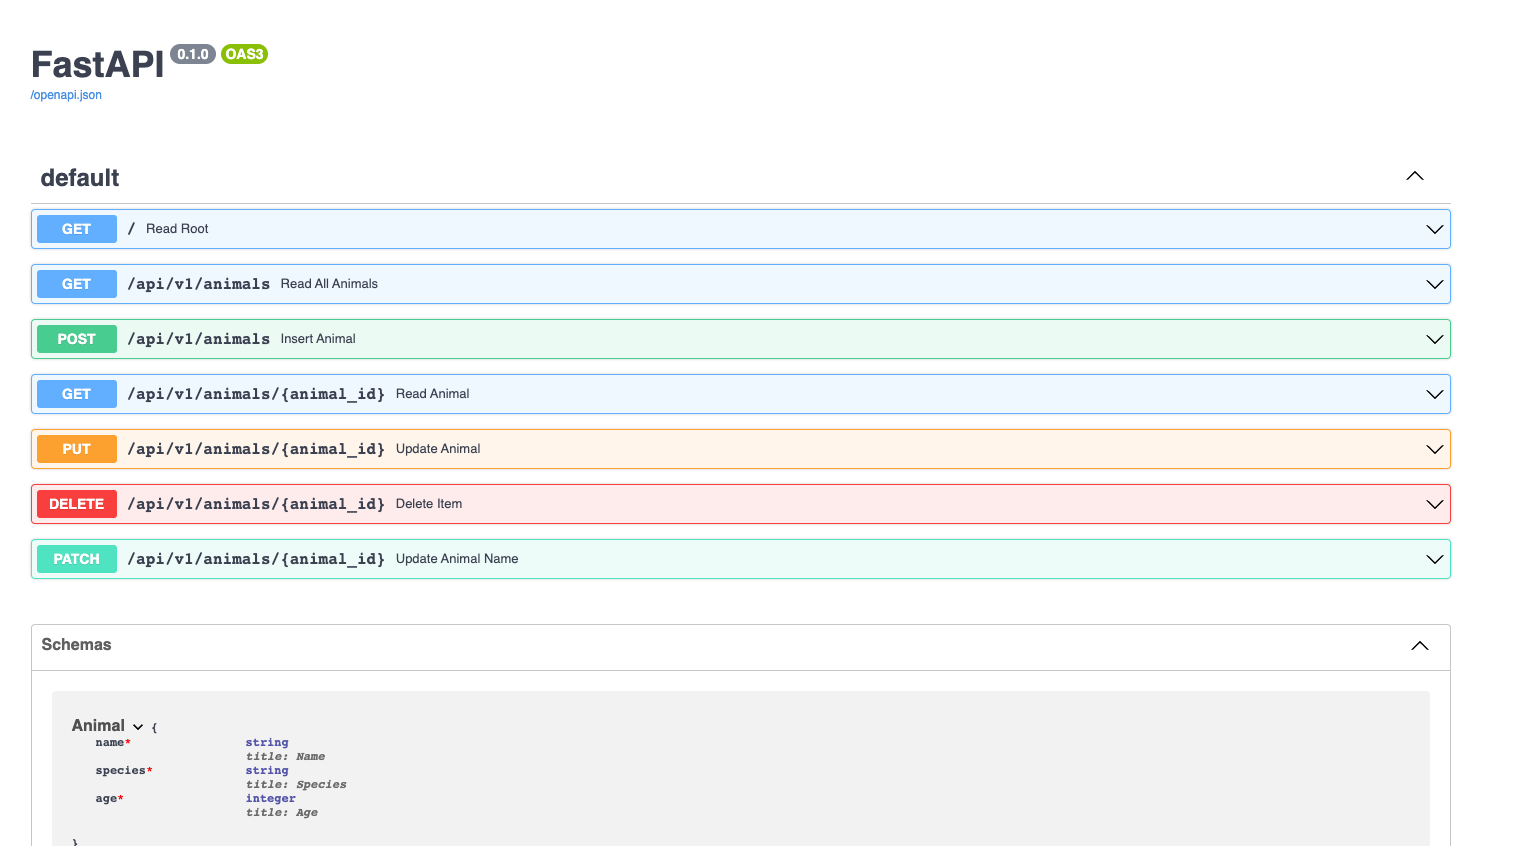


But, we can make it better:

```python
# example_one_w_documentation.py -- Runs on http://localhost:8001

from fastapi import FastAPI, HTTPException, Path, Body
from pydantic import BaseModel
import uvicorn


class Animal(BaseModel):
    name: str
    species: str
    age: int
        

tags_metadata = [
    {
        "name":"Create",
        "description": "These endpoints create new internal resources.",
    },
    {
        "name": "Read",
        "description": "These endpoints read existing internal resources.",
    },
    {
        "name": "Update",
        "description": "These endpoints update an existing internal resource.",
        "externalDocs": {
            "description": "External docs",
            "url": "https://fastapi.tiangolo.com/",
        },
    },
    {
        "name": "Delete",
        "description": "These endpoints remove existing internal resources.",
    },
]

app = FastAPI(openapi_tags=tags_metadata)

animal_cache = dict()


@app.get("/", 
         summary="Root Endpoint", 
         description="A simple root endpoint for the FastAPI application.",
         tags=["Read"])
def read_root():
    return {"message": "Hello, FastAPI!"}


@app.get("/api/v1/animals/{animal_id}",
         summary="Get an Animal",
         description="Retrieve an animal by its ID.",
         tags=["Read"])
def read_animal(animal_id: int = Path(..., description="The ID of the animal to retrieve.")):
    if animal_id in animal_cache:
        return {"animal": animal_cache[animal_id].dict()}
    else:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )


@app.post("/api/v1/animals/",
          summary="Create an Animal",
          description="Create a new animal with the provided details.",
         tags=["Create"])
def insert_animal(animal: Animal = Body(..., example={"name": "Tiger", "species": "Panthera tigris", "age": 3})):
    new_id = max(animal_cache.keys() or [0])
    animal_cache[new_id] = animal
    return {"animal": animal}


@app.put("/api/v1/animals/{animal_id}",
         summary="Update an Animal",
         description="Update an entire existing animal by providing its ID and the updated details.",
         tags=["Update"])
def update_animal(animal_id: int = Path(..., description="The ID of the animal to update."),
                animal: Animal = Body(..., example={"name": "Lion", "species": "Panthera leo", "age": 4})):
    if animal_id in animal_cache:
        animal_cache[animal_id] = animal
        return {"animal_id": animal_id, "animal": animal_cache[animal_id]}
    else:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )
        
@app.patch("/api/v1/animals/{animal_id}",
           summary="Update an Animal",
           description="Update a partial existing animal by providing its ID and the new name.",
           tags=["Update"])
def update_animal_name(animal_id: int, animal: AnimalName):
    if animal_id in animal_cache:
        animal_record = animal_cache[animal_id]
        animal_data = animal.dict(exclude_unset=True)
        for key, value in animal_data.items():
            setattr(animal_record, key, value)
        animal_cache[animal_id] = animal_record
        return {"animal_id": animal_id, "animal": animal_cache[animal_id]}
    else:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )



@app.delete("/api/v1/animals/{animal_id}",
            summary="Delete an Animal",
            description="Delete an existing animal by providing its ID.",
            tags=["Delete"])
def delete_animal(animal_id: int = Path(..., description="The ID of the animal to delete.")):
    if animal_id in animal_cache:
        del animal_cache[animal_id]
        return {"animal_id": animal_id, "message": "Animal removed"}
    else:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )
```

In [17]:
!nohup python example_one_w_docs.py > example_one_w_docs.log 2>&1 &

0

In [18]:
!ps aux | grep "python example_one_w_docs" | grep -v grep

chasehudson      19446   0.1  0.1 409340080  48336   ??  S     4:17PM   0:00.23 python example_one_w_docs.py


0

In [ ]:
!kill $(ps aux | grep "python example_one_w_docs" | grep -v grep | awk '{print $2}')

## Advanced Features

### Database Management

In the example above, we used an in memory cache to keep track of reasources. However, the most common approach is to have your REST API backed by a transactional database. We will look at an example implementation using SQLite, but first, we need to briefly touch on dependency injection

#### Dependency Injection

Dependency injection is a technique used to manage dependencies (objects or services) that a function requires. It allows you to create reusable, modular, and easily testable components by decoupling their dependencies from their implementation. In FastAPI, you define dependency functions using the Depends class to manage these dependencies.

To see why this is useful, let's look at to examples, one with dependency injection:


```python
from fastapi import FastAPI, Depends, HTTPException
from sqlalchemy import create_engine, Column, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, Session

# Create the SQLAlchemy engine
DATABASE_URL = "sqlite:///./test.db"
engine = create_engine(DATABASE_URL)

# Create the session factory
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

# Define the base class for SQLAlchemy models
Base = declarative_base()

# Define an example model
class Item(Base):
    __tablename__ = "items"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, index=True)

# Dependency for providing a database session
def get_db():
    db = SessionLocal()
    try:
        yield db
    finally:
        db.close()

app = FastAPI()

@app.get("/items/{item_id}")
async def read_item(item_id: int, db: Session = Depends(get_db)):
    item = db.query(Item).filter(Item.id == item_id).first()
    if item is None:
        raise HTTPException(status_code=404, detail="Item not found")
    return item
```

and one without:

```python
from fastapi import FastAPI, HTTPException
from sqlalchemy import create_engine, Column, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, Session

# Create the SQLAlchemy engine
DATABASE_URL = "sqlite:///./test.db"
engine = create_engine(DATABASE_URL)

# Create the session factory
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

# Define the base class for SQLAlchemy models
Base = declarative_base()

# Define an example model
class Item(Base):
    __tablename__ = "items"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, index=True)

app = FastAPI()

@app.get("/items/{item_id}")
async def read_item(item_id: int):
    db = SessionLocal()
    item = db.query(Item).filter(Item.id == item_id).first()
    db.close()
    if item is None:
        raise HTTPException(status_code=404, detail="Item not found")
    return item
```


Now let's discuss the differences between the two approaches and the advantages of using dependency injection:

Resource management: Without dependency injection, you need to manually open and close the database session in each route handler that requires access to the database. This is not only repetitive but also prone to errors, as you might forget to close the session or handle exceptions that could occur while accessing the database. With dependency injection, the responsibility of creating and closing the session is delegated to the dependency function, ensuring proper resource management.

Scoping: In the non-dependency injection example, we are creating and closing the session within the same route handler function. This is less flexible than using dependency injection because you can't easily control the session's lifecycle. With dependency injection, you can easily switch between different session management strategies (e.g., having a single session per request or sharing a session across multiple requests) by just changing the dependency function.

Testing: Without dependency injection, the read_item function is tightly coupled to the actual database session. This makes it more difficult to write unit tests, as you cannot easily replace the session with a mock object or an in-memory database. With dependency injection, the function receives the session as a parameter, making it easy to substitute the actual session with a test double.

#### Example Two

Let's take take Example One and have our resources stored persistently in a DB instead of ephimerally as an in-memory cache:

```python
from fastapi import FastAPI, Depends, HTTPException
from sqlalchemy import create_engine, Column, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, Session
from pydantic import BaseModel
import uvicorn


# Define the base class for SQLAlchemy models
Base = declarative_base()

class Animal(Base):
    __tablename__ = "animals"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String)  # If working with MySql, make sure to add length (e.g., Column(String(255)) )
    species = Column(String)
    age = Column(Integer)


DATABASE_URL = "sqlite:///./test.db"
app = FastAPI()

Engine = create_engine(
        DATABASE_URL,
        connect_args={"check_same_thread": False},
        native_datetime=True,)

# Add a function for creating SessionLocal to aid in setting up unit tests
def create_db(engine):
    SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
    Base.metadata.create_all(bind=engine)

    return SessionLocal

SessionLocal = create_db(Engine)
app = FastAPI()


class AnimalSchema(BaseModel):
    name: str
    species: str
    age: int


class AnimalNameSchema(BaseModel):
    name: str


# Dependency for providing a database session
def get_db():
    db = SessionLocal()
    try:
        yield db
    finally:
        db.close()


@app.get("/")
def read_root():
    return {"message": "Hello, FastAPI!"}


@app.get("/api/v1/animals")
def read_all_animals(db: Session = Depends(get_db)):
    animals = db.query(Animal).all()
    return {"animals": animals}


@app.post("/api/v1/animals")
def insert_animal(request: AnimalSchema, db: Session = Depends(get_db)):
    new_animal = Animal(name=request.name,
                        species=request.species,
                        age=request.age)
    db.add(new_animal)
    db.commit()
    db.refresh(new_animal)
    return {"animal": new_animal}

@app.get("/api/v1/animals/{animal_id}")
def read_animal(animal_id: int, db: Session = Depends(get_db)):
    animal_record = db.query(Animal).filter(Animal.id == animal_id).first()
    if animal_record is None:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )
    return {"animal": animal_record}


@app.post("/api/v1/animals")
def insert_animal(request: AnimalSchema, db: Session = Depends(get_db)):
    new_animal = Animal(name=request.name,
                        species=request.species,
                        age=request.age)
    db.add(new_animal)
    db.commit()
    db.refresh(new_animal)
    return {"animal": new_animal}


@app.put("/api/v1/animals/{animal_id}")
def update_animal(animal_id: int, animal: AnimalSchema, db: Session = Depends(get_db)):
    animal_record = db.query(Animal).filter(Animal.id == animal_id).first()
    if animal_record is None:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )
    animal_data = animal.dict(exclude_unset=True)
    for key, value in animal_data.items():
        setattr(animal_record, key, value)
    db.add(animal_record)
    db.commit()
    updated_animal_record = db.query(Animal).filter(Animal.id == animal_id).first()
    return {"animal_id": animal_id, "animal": updated_animal_record}


@app.patch("/api/v1/animals/{animal_id}")
def update_animal_name(animal_id: int, animal: AnimalNameSchema, db: Session = Depends(get_db)):
    animal_record = db.query(Animal).filter(Animal.id == animal_id).first()
    if animal_record is None:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )
    animal_data = animal.dict(exclude_unset=True)
    for key, value in animal_data.items():
        setattr(animal_record, key, value)
    db.add(animal_record)
    db.commit()
    updated_animal_record = db.query(Animal).filter(Animal.id == animal_id).first()
    return {"animal_id": animal_id, "animal": updated_animal_record}


@app.delete("/api/v1/animals/{animal_id}")
def delete_item(animal_id: int, db: Session = Depends(get_db)):
    animal_record = db.query(Animal).filter(Animal.id == animal_id).first()
    if animal_record is None:
        raise HTTPException(
            status_code=400, detail=f"Could not find animal with id: {animal_id}"
        )
    db.delete(animal_record)
    db.commit()
    return {"animal_id": animal_id, "message": "Animal removed"}
```

In [31]:
!nohup python example_two.py > example_two.log 2>&1 &

0

In [30]:
!ps aux | grep "python example_two"  | grep -v grep

256

In [32]:
response = requests.get("http://localhost:8002/api/v1/animals")
pprint.pprint(response.json())

{'animals': [{'age': 4,
              'id': 1,
              'name': 'Burr',
              'species': 'canis lupus familiaris'},
             {'age': 8,
              'id': 2,
              'name': 'Shadow',
              'species': 'equus caballus'}]}


In [22]:
headers = {'Content-type': 'application/json'}
dog = {"name": "Hamilton", "age": 4, "species": "canis lupus familiaris"}
response = requests.post("http://localhost:8002/api/v1/animals", headers=headers, json=dog)
pprint.pprint(response.json())

{'animal': {'age': 4,
            'id': 1,
            'name': 'Hamilton',
            'species': 'canis lupus familiaris'}}


In [23]:
headers = {'Content-type': 'application/json'}
donkey = {"name": "Cujo", "age": 6, "species": "equus asinus"}
response = requests.post("http://localhost:8002/api/v1/animals", headers=headers, json=donkey)
pprint.pprint(response.json())

{'animal': {'age': 6, 'id': 2, 'name': 'Cujo', 'species': 'equus asinus'}}


In [24]:
response = requests.get("http://localhost:8002/api/v1/animals")
pprint.pprint(response.json())

{'animals': [{'age': 4,
              'id': 1,
              'name': 'Hamilton',
              'species': 'canis lupus familiaris'},
             {'age': 6, 'id': 2, 'name': 'Cujo', 'species': 'equus asinus'}]}


In [25]:
horse = {"name": "Shadow", "age": 8, "species": "equus caballus"}
response = requests.put("http://localhost:8002/api/v1/animals/2", headers=headers, json=horse)
pprint.pprint(response.json())

{'animal': {'age': 8, 'id': 2, 'name': 'Shadow', 'species': 'equus caballus'},
 'animal_id': 2}


In [26]:
response = requests.get("http://localhost:8002/api/v1/animals")
pprint.pprint(response.json())

{'animals': [{'age': 4,
              'id': 1,
              'name': 'Hamilton',
              'species': 'canis lupus familiaris'},
             {'age': 8,
              'id': 2,
              'name': 'Shadow',
              'species': 'equus caballus'}]}


In [27]:
new_name = {"name": "Burr"}
response = requests.patch("http://localhost:8002/api/v1/animals/1", headers=headers, json=new_name)
pprint.pprint(response.json())

{'animal': {'age': 4,
            'id': 1,
            'name': 'Burr',
            'species': 'canis lupus familiaris'},
 'animal_id': 1}


In [28]:
response = requests.get("http://localhost:8002/api/v1/animals")
pprint.pprint(response.json())

{'animals': [{'age': 4,
              'id': 1,
              'name': 'Burr',
              'species': 'canis lupus familiaris'},
             {'age': 8,
              'id': 2,
              'name': 'Shadow',
              'species': 'equus caballus'}]}


In [ ]:
response = requests.delete("http://localhost:8002/api/v1/animals/2", headers=headers, json=new_name)
pprint.pprint(response.json())

In [ ]:
response = requests.get("http://localhost:8002/api/v1/animals")
pprint.pprint(response.json())

In [29]:
!kill $(ps aux | grep "python example_two" | grep -v grep | awk '{print $2}')

0

### Security

FastAPI makes use of OAuth2 and jwt (JSON Web Token) to authenticate users and create secure endpoints. A brief note about JWTs, JWTs are really just an agreed upon standard for signing and/or encrypting JSON whose payload asserts a particular set of claims.


I will not spend too much time on this section, but wanted to provide an example for reference:

```python
# security_example.py -- Runs on http://localhost:8005

from fastapi import FastAPI, Depends, HTTPException, status
from fastapi.security import OAuth2PasswordBearer
from pydantic import BaseModel
import jwt
import datetime
from typing import Optional

# Secret key for encoding and decoding JWT
SECRET_KEY = "supersecretkey"

# OAuth2PasswordBearer instance for handling tokens
oauth2_scheme = OAuth2PasswordBearer(tokenUrl="token")

app = FastAPI()

# Mock user data
fake_users_db = {
    "user1": {
        "username": "user1",
        "password": "password1",
    }
}

class Token(BaseModel):
    access_token: str
    token_type: str


class TokenData(BaseModel):
    username: Optional[str] = None


def create_jwt_token(data: dict):
    expiration = datetime.timedelta(hours=1)
    payload = {**data, "exp": datetime.datetime.utcnow() + expiration}
    token = jwt.encode(payload, SECRET_KEY, algorithm="HS256")
    return token

def decode_jwt_token(token: str):
    try:
        payload = jwt.decode(token, SECRET_KEY, algorithms=["HS256"])
        return payload
    except jwt.ExpiredSignatureError:
        raise HTTPException(
            status_code=status.HTTP_401_UNAUTHORIZED,
            detail="Token has expired",
            headers={"WWW-Authenticate": "Bearer"},
        )
    except jwt.InvalidTokenError:
        raise HTTPException(
            status_code=status.HTTP_401_UNAUTHORIZED,
            detail="Invalid token",
            headers={"WWW-Authenticate": "Bearer"},
        )

def get_current_user(token: str = Depends(oauth2_scheme)):
    payload = decode_jwt_token(token)
    username: str = payload.get("sub")
    if username is None:
        raise HTTPException(
            status_code=status.HTTP_401_UNAUTHORIZED,
            detail="Invalid authentication credentials",
            headers={"WWW-Authenticate": "Bearer"},
        )
    return fake_users_db.get(username)

@app.post("/api/v1/token", response_model=Token)
def login(form_data: dict):
    username = form_data.get("username")
    password = form_data.get("password")

    user = fake_users_db.get(username)

    if not user or user.get("password") != password:
        raise HTTPException(
            status_code=status.HTTP_400_BAD_REQUEST,
            detail="Incorrect username or password",
            headers={"WWW-Authenticate": "Bearer"},
        )

    access_token = create_jwt_token({"sub": username})
    return {"access_token": access_token, "token_type": "bearer"}

@app.get("/api/v1/users/me")
def read_users_me(current_user: dict = Depends(get_current_user)):
    return current_user
```

In [ ]:
!nohup python security_example.py > security_example.log 2>&1 &

In [ ]:
!ps aux | grep "python security_example" | grep -v grep

In [ ]:
user = {"username": "user1",
        "password": "password1"}
response = requests.post("http://localhost:8005/api/v1/token", headers=headers, json=user)
pprint.pprint(response.json())

In [ ]:
!kill $(ps aux | grep "python security_example" | grep -v grep | awk '{print $2}')

### Async

You will often see FastAPI endpoints be defined with `async def` instead of just `def`. Many examples do this to illustrate that FastAPI has async capabilities built-in, but they will use `async def` on end points that do not actually make use of async capabilities. By convention, I only add `async def` when it is being used. Below is an example of when you actually need `async def`.


```python
# async_example.py -- Runs on http://localhost:8003

from fastapi import FastAPI
import httpx

app = FastAPI()

async def fetch_data(url: str):
    async with httpx.AsyncClient() as client:
        response = await client.get(url)
    return response.json()

@app.get("/api/v1/data")
async def get_data():
    url = "https://jsonplaceholder.typicode.com/todos/1"
    data = await fetch_data(url)
    return {"data": data}
```

In [33]:
!nohup python async_example.py > async_example.log 2>&1 &

0

In [34]:
!nohup python async_example_no_async.py > async_example_no_async.log 2>&1 &

0

In [35]:
!ps aux | grep "python async_example"  | grep -v grep

chasehudson      19731   0.0  0.1 409348272  48304   ??  S     4:25PM   0:00.23 python async_example_no_async.py
chasehudson      19725   0.0  0.1 409487536  48608   ??  S     4:25PM   0:00.24 python async_example.py


0

In [36]:
%%timeit -r 2 -n 4
import requests


for i in range(10):
    response = requests.get("http://localhost:8003/api/v1/data")
    print(response.content)

b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut a

In [37]:
%%timeit -r 2 -n 4
import requests


for i in range(10):
    response = requests.get("http://localhost:8004/api/v1/data")
    print(response.content)

b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut autem","completed":false}}'
b'{"data":{"userId":1,"id":1,"title":"delectus aut a

In [ ]:
!kill $(ps aux | grep "python async_example" | grep -v grep | awk '{print $2}')

### Websockets

I won't cover this as this notebook is largely about the REST aspects of FastAPI and websockets are not part of RESTful architecture. That being said, websockets in FastAPI are incredibly interesting topic and one I recommend everyone read up on (see [docs](https://fastapi.tiangolo.com/advanced/websockets/)).

## Testing and Deployments

### Testing

FastAPI makes unit testing incredibly easy with the built in `TestClient` module. For instance, if we wanted to unit test our animal example [above](#Example-Two)

```python
import pytest
from fastapi.testclient import TestClient
from example_two import app, get_db, create_db, Base, Engine, Animal
from sqlalchemy.orm import sessionmaker
from sqlalchemy.pool import StaticPool
from sqlalchemy import create_engine


@pytest.fixture
def client():
    SQLALCHEMY_DATABASE_URL = "sqlite:///:memory:"
    engine = create_engine(
        SQLALCHEMY_DATABASE_URL, echo=True, connect_args={"check_same_thread": False}, poolclass=StaticPool
    )
    TestingSessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
    Base.metadata.create_all(bind=engine)
    def override_get_db():
        try:
            db = TestingSessionLocal()
            yield db
        finally:
            db.close()
    app.dependency_overrides[get_db] = override_get_db
    client = TestClient(app)
    return client


def test_read_root(client):
    response = client.get("/")
    assert response.status_code == 200
    assert response.json() == {"message": "Hello, FastAPI!"}


def test_insert_animal(client):
    animal = {
        "name": "Doggo",
        "species": "Dog",
        "age": 5
    }
    response = client.post("/api/v1/animals", json=animal)
    assert response.status_code == 200
    assert response.json()["animal"]["name"] == "Doggo"


def test_read_animals(client):
    animal = {
        "name": "Doggo",
        "species": "Dog",
        "age": 5
    }
    response = client.post("/api/v1/animals", json=animal)
    response = client.get("/api/v1/animals")
    assert response.status_code == 200
    assert len(response.json()["animals"]) > 0


def test_read_animal(client):
    animal_id = 1
    response = client.get(f"/api/v1/animals/{animal_id}")
    assert response.status_code == 400
    assert response.json()["detail"] == f"Could not find animal with id: {animal_id}"


def test_update_animal(client):
    animal_id = 1
    updated_animal = {
        "name": "Updated Doggo",
        "species": "Dog",
        "age": 6
    }
    response = client.put(f"/api/v1/animals/{animal_id}", json=updated_animal)
    print(response.json())
    assert response.status_code == 400
    assert response.json()["detail"] == f"Could not find animal with id: {animal_id}"


def test_update_animal_name(client):
    animal_id = 1
    updated_animal = {
        "name": "New Name",
    }
    response = client.patch(f"/api/v1/animals/{animal_id}", json=updated_animal)
    assert response.status_code == 400
    assert response.json()["detail"] == f"Could not find animal with id: {animal_id}"


def test_delete_item(client):
    animal_id = 1
    response = client.delete(f"/api/v1/animals/{animal_id}")
    assert response.status_code == 400
    assert response.json()["detail"] == f"Could not find animal with id: {animal_id}"
```

In [38]:
!pytest test_example.py -v

============================= test session starts ==============================
platform darwin -- Python 3.10.9, pytest-7.2.2, pluggy-1.0.0 -- /Users/chasehudson/miniforge3/envs/code-dojo-10/bin/python3.10
cachedir: .pytest_cache
rootdir: /Users/chasehudson/code/code-dojo/modules/06_rest_api_fastapi
plugins: anyio-3.6.2
collecting ... collected 7 items

test_example.py::test_read_root PASSED                                   [ 14%]
test_example.py::test_insert_animal PASSED                               [ 28%]
test_example.py::test_read_animals PASSED                                [ 42%]
test_example.py::test_read_animal PASSED                                 [ 57%]
test_example.py::test_update_animal PASSED                               [ 71%]
test_example.py::test_update_animal_name PASSED                          [ 85%]
test_example.py::test_delete_item PASSED                                 [100%]

=============================== warnings summary ===============================


0

### Deployment

```docker
FROM python:3.9

WORKDIR /app

COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

COPY . .

CMD ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "8000"]
```

## Resources

* https://www.ics.uci.edu/~fielding/pubs/dissertation/rest_arch_style.htm
* https://betterprogramming.pub/fastapi-best-practices-1f0deeba4fce